# Covid Data analysis

There are a lot of assumptions and very complicated modeling that go into prediction of covid-19 infection rates. Behavioral factors figure prominently in making it difficult to predict daily new infection rates. For instance, if infection rates rise, people may react and behave more cautiously and as they fall they may behave more freely. This is a classic differential equation problems in that the effects lag behavior and cause yet additional effects. These problems are usually specified by a damped sine + cosine function. And these behavioral wobbles are further superimposed on the natural exponential spread of infections.

However, now that the medical community has identified the best course of treatment for the disease, hospitalization and death rates are very straightforward to extrapolate from new daily infections that are reported.

This workbook illustrates the relationship between new daily infections and eventual deaths from these new infections. The data is pulled live from the [Covid Tracking Project](covidtracking.com) API.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Import data
data = "https://api.covidtracking.com/v1/us/daily.csv"
df = pd.read_csv(data)
# df.head() look at data table if needed

## Download data from the Covid tracking project

The dump from the data API shows quite a few fields in this data table. This analysis will concentrate only on the date, the daily new infections ('positiveIncrease'), and the daily new deaths('deathIncrease'). The following code whittles down the data to what we need to look at. The data also need to be flipped because the API reports them with the most recent data at the top of the file. 

In [2]:
# Mung the data a little
def reset_my_index(df):
  res = df[::-1].reset_index(drop=True) # function to reverse order of row and resets index
  return(res)

df['date']= pd.to_datetime(df['date'],format='%Y%m%d') # converts date to datetime field

df = reset_my_index(df) # reverse order of dataframe so later dates are last

df = df.loc[:,['date','positiveIncrease','deathIncrease','hospitalizedIncrease']] # select columns to work with

# print( df.tail(30)) # confirm later dates are at end


Install the basic plotting library to look at the results and then plot the two data fields.

Text(0, 0.5, 'Daily new deaths')

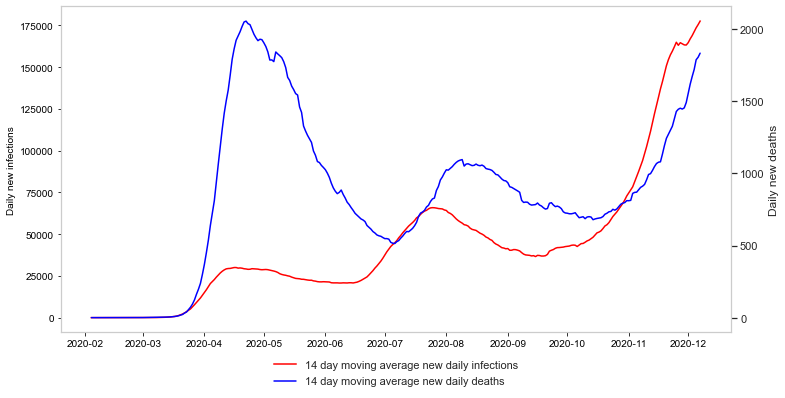

In [3]:
# install plot library
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(figsize=(12,6))

rolling_avg = 14 # number of days to use for rolling average - probably should be multiple of 7

ax.plot(df.date,df['positiveIncrease'].rolling(window=rolling_avg).mean(),color='red',label='14 day moving average new daily infections')
sns.set()
sns.set_style("whitegrid")
ax.set_ylabel('Daily new infections')

ax2=ax.twinx()
ax2.plot(df.date, df["deathIncrease"].rolling(window=rolling_avg).mean(), color="blue",label='14 day moving average new daily deaths')
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.10))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.15))
#ax2.plot(df.date, df['hospitalizedIncrease'].rolling(window=rolling_avg).mean(),color='green')
ax2.grid(False) # turn off grid for second Y axis
ax2.set_ylabel('Daily new deaths')

## Estimate the lag between new infections and new deaths

It is clear from the plot that the curves are similar in shape. The blue curve is daily deaths (right axis) and the red curve is daily new infections (left) axis. If the death curve is shifted back in time, it looks like it will mirror very closely the new infection curve, at least for the most recent data. The big gap at the beginning of the dataset is due to the novel nature of the coronavirus and the uncertainty about how best to treat it. The next plot shifts the death curve back by the 'lag' value, which can be adjusted to get the best visual correlation. It turns out that 21 days is about perfect.

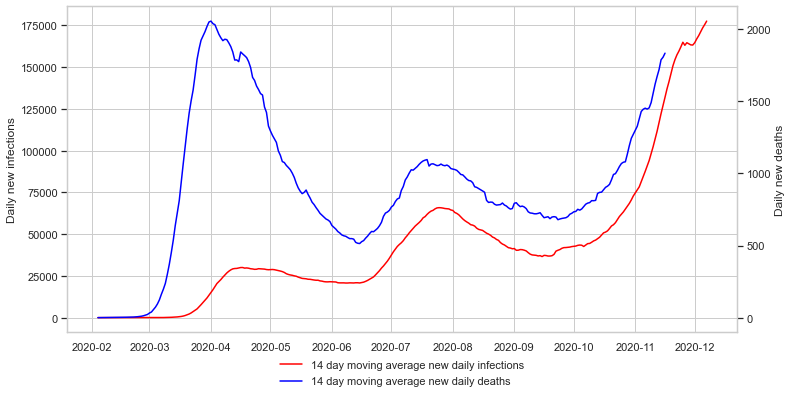

In [4]:
lag = -21 # number of days from current day that prediction factor occurs
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(df.date,df['positiveIncrease'].rolling(window=rolling_avg).mean(),color='red',label='14 day moving average new daily infections')
ax.set_ylabel('Daily new infections')
ax2=ax.twinx()
ax2.plot(df.date, df["deathIncrease"].shift(lag).rolling(window=rolling_avg).mean(), color="blue",label='14 day moving average new daily deaths')
ax2.grid(False) # turn off grid for second Y axis
ax2.set_ylabel('Daily new deaths')
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.10))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.15))

## Find the fraction of deaths that result from new infections using the lagged death data

The next step is to find the relationship between lagged deaths and initial infections. To do this, a death prediction factor (or scalar) is created for each day by dividing the daily death by the daily infections from 21 days earlier. Once this is graphed, it is clear that the relationship has been fairly steady after the initial infections in April and May. The red line is daily data and the blue line is the 14 day moving average for this factor.

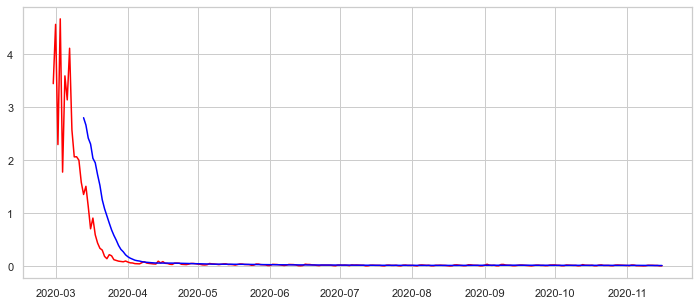

In [5]:
# calculate relationship between lagged new daily infections and current daily deaths
df["death_prediction_scalar"] = df["deathIncrease"].shift(lag)/df["positiveIncrease"] # lags deaths back in time by the lag value for this calculation
fig,ax = plt.subplots(figsize=(12,5))
sns.set()
sns.set_style("whitegrid")
ax.plot(df.date,df['death_prediction_scalar'],color='red')
ax.plot(df.date, df["death_prediction_scalar"].rolling(window=rolling_avg).mean(), color="blue")

Zooming in on the data after June 1 shows this to be a very stable relationship.

In [6]:
# start plotting from June 1 because that is where the relationship seems stable
from datetime import datetime,timedelta
start_date = datetime(2020,6,1,0,0,0) # arbitrary starting date
future = str(f'{lag} days') # extend into future using lag value
end_date = datetime.now() + pd.to_timedelta(future) #extend end date into future by lag value

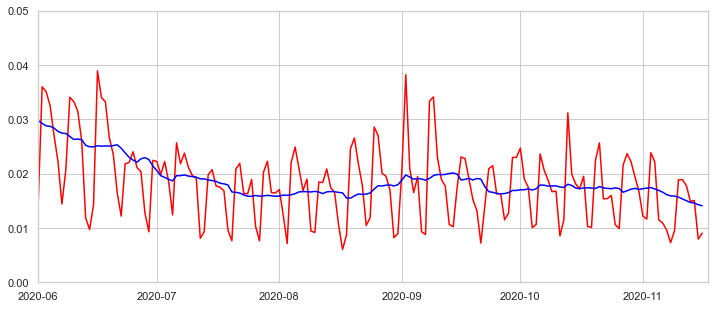

In [7]:
# plot a zoomed in look at data since June 1
fig,ax = plt.subplots(figsize=(12,5))
plt.xlim([start_date,end_date])
plt.ylim(0,0.05)
sns.set()
sns.set_style("whitegrid")
ax.plot(df.date,df['death_prediction_scalar'],color='red')
ax.plot(df.date, df["death_prediction_scalar"].rolling(window=rolling_avg).mean(), color="blue")

## Calculate an average death per infection to use for prediction

For the purposes of this analysis, only the last 45 days of the 'daily new infection'/'lagged daily death' is used. The average of this value is the 'death factor'. This value is then copied to a new column in the dataframe. Anther new column is then added that is the predicted death column based on this death factor. Plotting this against the actual data since June shows it is a very strong relationship, even without running this through a regression routine. The actual data is in red and the predicted is blue. A 14 day moving average is used to take out weekly effects in data reporting.

In [8]:
# calculate an average death rate from lagged data
avg_death_from_positive_cases = df["death_prediction_scalar"].rolling(window=rolling_avg).mean()
stable_period = 45
start = lag - stable_period # calculates the index from end of dataframe to start the calculation
death_factor = avg_death_from_positive_cases[start:lag].mean() # average of smoothed data

In [9]:
# copy death scalar to an entire column

df['avg_death_factor'] = [death_factor] * len(df.index) # copies value to entire column

df['predicted_death'] = df['positiveIncrease'] * df['avg_death_factor']


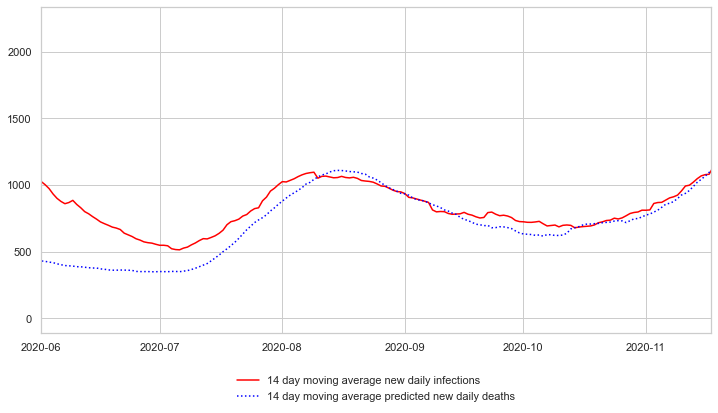

In [10]:
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(df.date,df['deathIncrease'].rolling(window=rolling_avg).mean(),color='red',label='14 day moving average new daily infections')
sns.set()
sns.set_style("whitegrid")
ax.plot(df.date, df['predicted_death'].shift(-lag).rolling(window=rolling_avg).mean(), color="blue",linestyle=":",label='14 day moving average predicted new daily deaths')
plt.xlim([start_date,end_date]) # moves the prediction forward in time to match the lag as a check
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.17))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.22))


## Add future dates for prediction

Now let's add some future data rows to the dataframe to see what to expect and plot it. The daily deaths expected over the next few weeks will inevitably rise with this predictive model.

In [11]:
df = df.append(pd.DataFrame({'date': pd.date_range(start=df.date.iloc[-1], periods=-lag, freq='D', closed='right')}))
df = df.reset_index() # resets index after what is essentially appending another dataframe
df['avg_death_factor'] = [death_factor] * len(df.index) # copies value to entire column

In [12]:
df['predicted_death'] = df['positiveIncrease'].shift(-lag) * df['avg_death_factor'] # predicts future deaths from lagged initial cases

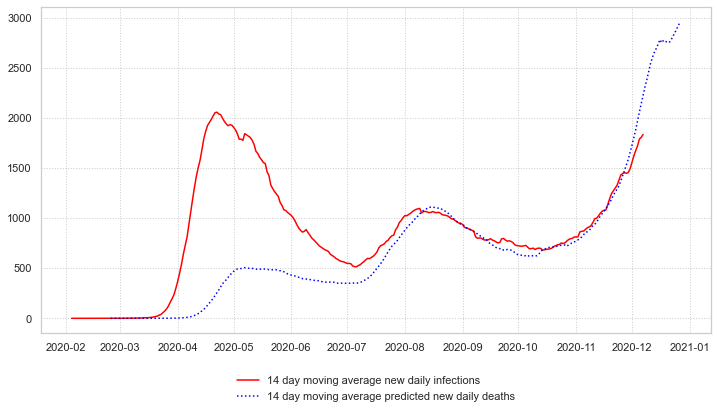

In [13]:
fig,ax = plt.subplots(figsize=(12,6))
plt.grid(axis='both',linestyle=':',linewidth='1')
sns.set()
sns.set_style("whitegrid")
ax.plot(df.date,df['deathIncrease'].rolling(window=rolling_avg).mean(),color='red',label='14 day moving average new daily infections')
ax.plot(df.date, df['predicted_death'].rolling(window=rolling_avg).mean(), color="blue",linestyle=":",label='14 day moving average predicted new daily deaths')
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.17))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.49, -0.22))

## Evaluate statistics on prediction

In [14]:
from sklearn.metrics import r2_score
# create columns of 14 day smoothed data
start_R_calc = 192 # index value for Aug 1 2020
df['deathIncrease-14daysmoothed'] = df['deathIncrease'].rolling(window=rolling_avg).mean()
df['predicted_Death-14daysmoothed'] = df['predicted_death'].rolling(window=rolling_avg).mean()
model = df[start_R_calc:316]['deathIncrease-14daysmoothed']
prediction = df[start_R_calc:316]['predicted_Death-14daysmoothed']

R2 = r2_score(model,prediction)
print(f"R^2 Analysis start date is {df.loc[start_R_calc,'date']:%m %d %Y}")
print(f"R^2 value is {R2:.2f}")


R^2 Analysis start date is 08 01 2020
R^2 value is 0.92


## Cumulative death prediction

Now that we have actual and predicted death data, we can create additional columns of data to calculate the total number of deaths to date and then estimate the future cumulative deaths. The last cell prints out the current cumulative deaths. The cumulative deaths are plotted on a separate axis in green (the right axis labels).

In [15]:
df['cumulative_deaths'] = df['deathIncrease'].cumsum(axis=0)
current_death_total = df.at[df.index[-1]+lag+1,'cumulative_deaths'] # picks out the last actual death cumulative total
print(current_death_total)

274745.0


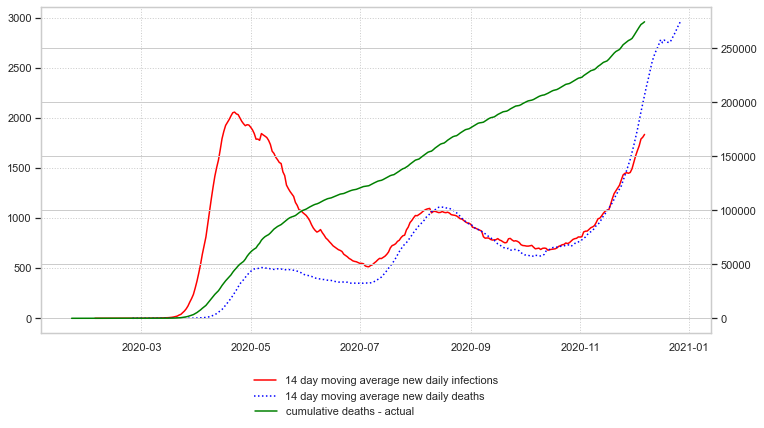

In [16]:
fig,ax = plt.subplots(figsize=(12,6))
plt.grid(axis='both',linestyle=':',linewidth='1')
sns.set()
sns.set_style("whitegrid")
ax.plot(df.date,df['deathIncrease'].rolling(window=rolling_avg).mean(),color='red',label='14 day moving average new daily infections')
ax.plot(df.date, df['predicted_death'].rolling(window=rolling_avg).mean(), color="blue",linestyle=":",label='14 day moving average new daily deaths')
ax2=ax.twinx()
ax2.plot(df.date, df['cumulative_deaths'],color='green',label='cumulative deaths - actual')
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.17))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.438, -0.24))

## Estimate future death totals

Finally, a last column of data is calculated to show the future cumulative death totals. It is plotted on the same axis as the actual cumulative death total, but is dashed instead of solid.

In [17]:
begin = lag+1 # position where predictions start

df['predict_cum'] = df['predicted_death'][lag+1:].cumsum()
df['predict_cum'] = df['predict_cum'] + current_death_total


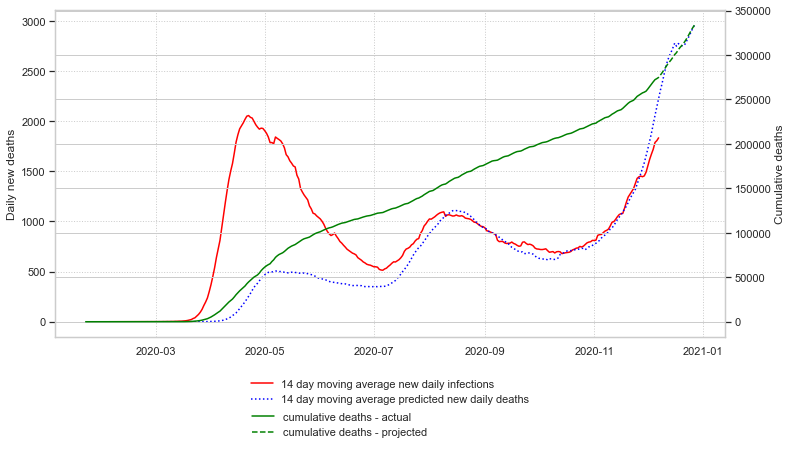

In [18]:
fig,ax = plt.subplots(figsize=(12,6))
plt.grid(axis='both',linestyle=':',linewidth='1')
sns.set()
sns.set_style("whitegrid")
ax.plot(df.date,df['deathIncrease'].rolling(window=rolling_avg).mean(),color='red',label='14 day moving average new daily infections')
ax.plot(df.date, df['predicted_death'].rolling(window=rolling_avg).mean(), color="blue",linestyle=":",label='14 day moving average predicted new daily deaths')
ax2=ax.twinx()
ax2.plot(df.date, df['cumulative_deaths'],color='green',label='cumulative deaths - actual')
ax2.plot(df.date, df['predict_cum'],color="green",linestyle="--",label='cumulative deaths - projected')
ax.set_ylabel('Daily new deaths')
ax2.set_ylabel('Cumulative deaths')
leg = ax.legend(loc='center', frameon=False,bbox_to_anchor=(0.5, -0.17))
leg2=ax2.legend(loc='center', frameon=False,bbox_to_anchor=(0.425, -0.27))

## Grim summary

In three weeks time, the US will have well over 320,000 total deaths.

In [19]:
last_prediction = df.index[-1]
print(f"Predicted total death toll on {df.loc[last_prediction,'date']:%b %d, %Y} is {df.loc[last_prediction,'predict_cum']:,.0f}")


Predicted total death toll on Dec 27, 2020 is 333,449
